# Natural Lenguage Processing

In [100]:
# Importar Librerías:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import specificity_score





In [59]:
#DataFrame:

data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


**Step 2: Preprocess the links**

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [61]:
data.is_spam = data.is_spam.apply(lambda x: 1 if x is True else 0)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


is_spam
0    2303
1     696
Name: count, dtype: int64


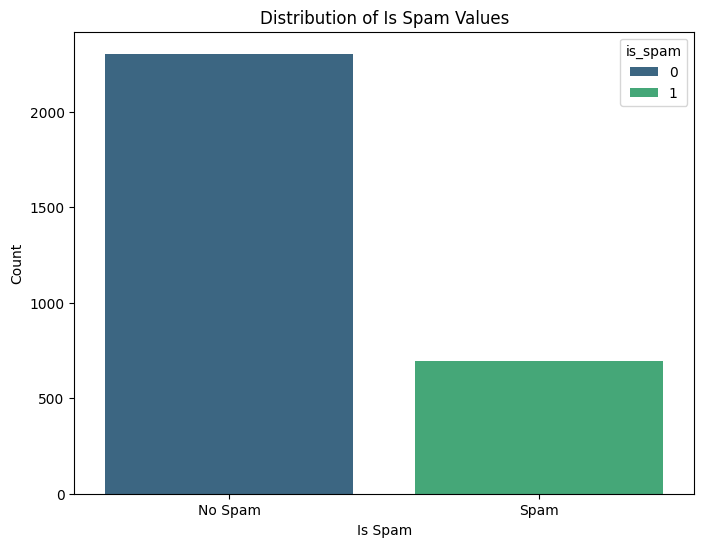

In [62]:
print(data.is_spam.value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spam', data=data, palette='viridis',hue='is_spam', dodge=False)
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.title('Distribution of Is Spam Values')
plt.xticks(ticks=[0, 1], labels=['No Spam', 'Spam'])
plt.show()


In [63]:
print(f"Valores Nulos = {data['url'].isna().sum()}")
print(f"Valores Duplicados = {data.duplicated().sum()}")

Valores Nulos = 0
Valores Duplicados = 630


In [64]:
data=data.drop_duplicates()
data.shape

(2369, 2)

is_spam
0    2125
1     244
Name: count, dtype: int64


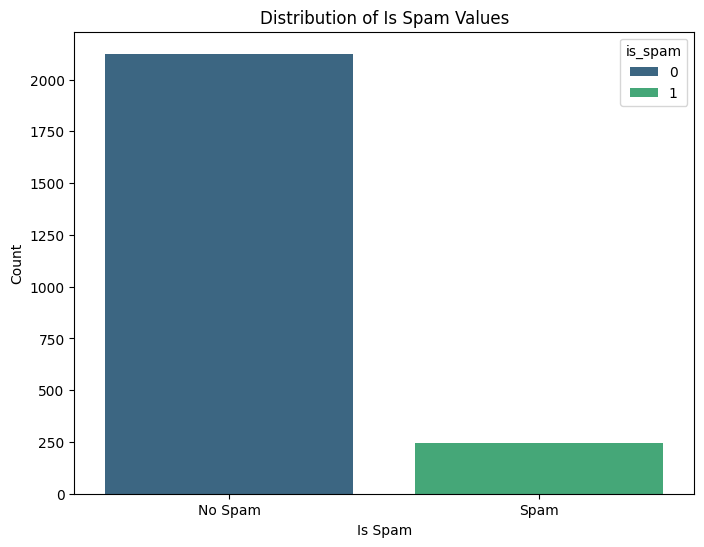

In [65]:
print(data.is_spam.value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spam', data=data, palette='viridis',hue='is_spam', dodge=False)
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.title('Distribution of Is Spam Values')
plt.xticks(ticks=[0, 1], labels=['No Spam', 'Spam'])
plt.show()

In [66]:
def procesar_texto(texto):
    texto = re.sub(r'[^a-z ]', " ", texto) # reemplazar los caracteres con un espacio en blanco
    
    texto = re.sub(r'\b[a-zA-Z]\b', ' ', texto) # eliminar letras sueltas
    
    texto = re.sub(r'^[a-zA-Z]\s+', ' ', texto) # eliminar letras sueltas
 
    texto = re.sub(r'^\s+', '', texto) #eliminar espacios en blanco
    
    texto = re.sub(r'\s+', " ", texto) #Dejar un solo espacio en blanco
    
    return texto.split() # divide una cadena en una lista de palabras utilizando los espacios en blanco como separadores

data["url"] = data["url"].apply(procesar_texto)
data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com]",1
3,"[https, briefingday, com, commentform]",0
4,"[https, briefingday, com, fan]",1


**Lematización**: La lematización es el proceso de reducir las palabras a su forma base o raíz (el lema).Utilizaremos WordNet, que es una base de datos léxica de la lengua inglesa incluida en NLTK (Natural Language Toolkit).

**Stopwords**: Las palabras vacías son palabras comunes que generalmente no contribuyen al significado del texto y se eliminan durante el procesamiento del lenguaje natural. Por ejemplo, "a", "the", "is", "in", etc.

In [73]:
nltk.download("wordnet")  # Descarga el recurso necesario para la lematización de palabras en WordNet, que es un diccionario léxico de inglés incluido en NLTK.
lemmatizer = WordNetLemmatizer()

nltk.download("stopwords") #  Descarga la lista de palabras vacías (stopwords) en inglés.
stop_words = stopwords.words("english") # Carga la lista de palabras vacías en inglés en unaa variable

# Función que toma una lista de palabras como entrada y aplica la lematización y eliminación de palabras vacías:
def lemmatize_text(words, lemmatizer = lemmatizer):
    text = [lemmatizer.lemmatize(word) for word in words] # Lematiza cada palabra en la lista de palabras de entrada.
    text = [word for word in text if word not in stop_words] # Elimina las palabras vacías de la lista lematizada.
    text = [word for word in text if len(word) > 3] # Elimina las palabras que tienen menos de 4 caracteres (opcional y se puede ajustar).
    return text # Devuelve la lista de palabras lematizadas y filtradas.

data["url"] = data["url"].apply(lemmatize_text)
data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


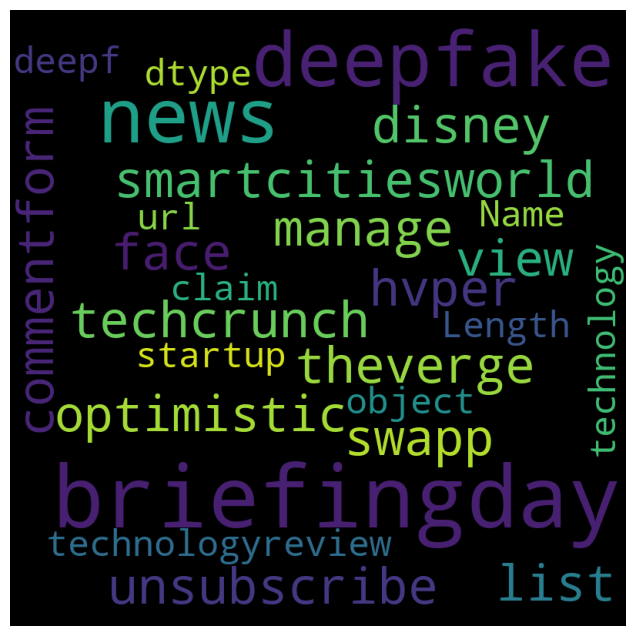

In [77]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [78]:
tokens_list = data["url"] # Se extraen los tokens de la columna "url" del DataFrame.
tokens_list = [" ".join(tokens) for tokens in tokens_list] # Se convierten las listas de tokens en cadenas de texto, con los tokens separados por un espacio en blanco.

# Esto es necesario porque TfidfVectorizer espera una lista de cadenas como entrada.

**TfidfVectorizer** es una herramienta de preprocesamiento de texto utilizada para convertir colecciones de documentos de texto en representaciones numéricas que pueden ser utilizadas como entrada para algoritmos de aprendizaje automático

In [82]:
#Se instancia TfidVectorizer

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
# max_features = 5000: limita el número máximo de características a 5000: solo se tendrán en cuenta las 5000 palabras más frecuentes.
# max_df = 0.8: ignora los términos que aparecen en más del 80% de los documentos. Esto ayuda a eliminar palabras comunes que no son muy útiles para distinguir entre diferentes documentos.
# min_df = 5: ignora los términos que aparecen en menos de 5 documentos. Esto ayuda a eliminar palabras poco frecuentes que pueden ser ruido en los datos.

In [81]:
# aplica el vectorizador a las cadenas de texto convirtiendolas en una matriz TF-IDF, donde cada fila representa un documento y cada columna representa una palabra.
X = vectorizer.fit_transform(tokens_list).toarray() # Luego, esta matriz se convierte en un arreglo NumPy.
y = data["is_spam"] # asigna las etiquetas de clase (en este caso, si el documento es spam o no) a la variable 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Step 3: Build an SVM**

In [88]:
# SVC (Support Vector Classifier)
model = SVC(kernel = "linear", random_state = 42)
# kernel="linear": se utilizará un kernel lineal.
# En SVM o Máquinas de Vectores de Soporte (Support Vector Machines), el kernel lineal es útil cuando se tiene un gran número de características y el número de muestras de datos es menor que el número de características.
# Además, el kernel lineal es computacionalmente más eficiente en comparación con otros kernels más complejos

model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [93]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9514767932489452

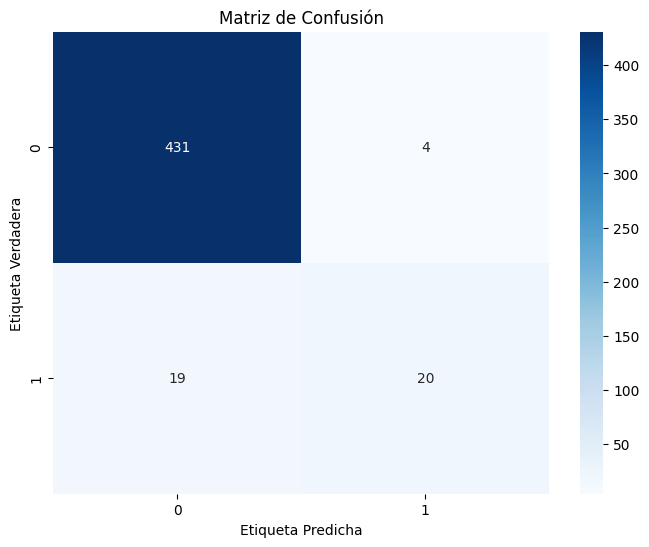

In [95]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

In [101]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

get_metrics(y_train, y_test, X_pred, y_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.937203,0.607261,0.722615,0.938776,0.448780,0.996450
Test,0.951477,0.634921,0.751813,0.833333,0.512821,0.990805
Diferencia,-0.014274,-0.027660,-0.029197,0.105442,-0.064040,0.005645
